- Use GPS Gridder from GMT to interpolate between GPS stations
- The algorithm is based on the greens functions for elastic sheets with a given Poisson's ratio. 
- From: Sandwell, D. T., and P. Wessel (2016), Interpolation of 2-D vector data using constraints from elasticity, Geophys. Res.Lett.

In [1]:
import numpy as np
import subprocess
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current directory
print("Current Working Directory:", current_directory)

Current Working Directory: /Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain-rate-seismicity/ntbk


In [3]:
# Define utility functions
def filter_by_bounding_box(velfield, bounding_box):
    """Filter the velocity field data by a given bounding box."""
    filtered = velfield[
        (velfield['Lon'] >= bounding_box[0]) &
        (velfield['Lon'] <= bounding_box[1]) &
        (velfield['Lat'] >= bounding_box[2]) &
        (velfield['Lat'] <= bounding_box[3])
    ]
    return filtered

def create_model_velfield(xdata, ydata, Ve, Vn, observed_velfield):
    """Create a model velocity field based on the interpolated velocities."""
    model_velfield = observed_velfield.copy()
    model_velfield['Ve'] = Ve.flatten()
    model_velfield['Vn'] = Vn.flatten()
    return model_velfield

def subtract_two_velfields(observed_velfield, model_velfield):
    """Subtract two velocity fields to get residual velocities."""
    residual_velfield = observed_velfield.copy()
    residual_velfield['Ve'] = observed_velfield['Ve'] - model_velfield['Ve']
    residual_velfield['Vn'] = observed_velfield['Vn'] - model_velfield['Vn']
    return residual_velfield

def get_string_range(range_values, x_buffer=0, y_buffer=0):
    """Get a range string for GMT commands."""
    return f"{range_values[0]-x_buffer}/{range_values[1]+x_buffer}/{range_values[2]-y_buffer}/{range_values[3]+y_buffer}"

def get_string_inc(inc_values):
    """Get an increment string for GMT commands."""
    return f"{inc_values[0]}/{inc_values[1]}"

def strain_on_regular_grid(xinc, yinc, udata, vdata):
    """Calculate strain tensor components on a regular grid and extend to dilatation and second invariant."""
    exx = np.gradient(udata, xinc, axis=1)  # Normal strain in the x-direction
    eyy = np.gradient(vdata, yinc, axis=0)  # Normal strain in the y-direction
    exy = 0.5 * (np.gradient(udata, yinc, axis=0) + np.gradient(vdata, xinc, axis=1))  # Shear strain
    rot = 0.5 * (np.gradient(vdata, xinc, axis=1) - np.gradient(udata, yinc, axis=0))  # Rotational component
    
    max_shear = 0.5*(np.sqrt((exx - eyy)**2 + 4*exy**2)) ## Based on Maurer and Materna (2023)

    # Calculate Dilatation
    dilatation = exx + eyy
    
    # Calculate Second Invariant
    second_invariant = np.sqrt((exx**2 + eyy**2 + 2*exy**2))
#     second_invariant = 0.5 * ((exx * eyy) - (exy**2))
    
    return exx, eyy, exy, rot, max_shear, dilatation, second_invariant

# Define the gpsgridder class
class gpsgridder:
    def __init__(self, params):
        self._grid_inc = params['inc']
        self._strain_range = params['range_strain']
        self._xdata = params['xdata']
        self._ydata = params['ydata']
        self._tempdir = params['outdir']
        self._poisson, self._fd, self._eigenvalue = self.verify_inputs_gpsgridder(params['method_specific'])

    def verify_inputs_gpsgridder(self, method_specific_dict):
        if 'poisson' not in method_specific_dict:
            raise ValueError("gps_gridder requires poisson's ratio. Please add to method_specific config.")
        if 'fd' not in method_specific_dict:
            raise ValueError("gps_gridder requires fudge factor fd. Please add to method_specific config.")
        if 'eigenvalue' not in method_specific_dict:
            raise ValueError("gps_gridder requires eigenvalue. Please add to method_specific config.")
        return method_specific_dict["poisson"], method_specific_dict["fd"], method_specific_dict["eigenvalue"]

    def compute(self, myVelfield):
        Ve, Vn, rot_grd, exx_grd, exy_grd, eyy_grd, max_shear_grd, dilatation_grd, second_invariant_grd = self.compute_gpsgridder(myVelfield)
        return max_shear_grd

    def compute_gpsgridder(self, myVelfield):
        print("Computing strain via gpsgridder method.")
        myVelfield.to_csv("tempgps.txt", sep=' ', index=False, header=False)
        command = f"gmt gpsgridder tempgps.txt -R{get_string_range(self._strain_range, self._grid_inc[0]/2, self._grid_inc[1]/2)} -I{get_string_inc(self._grid_inc)} -S{self._poisson} -Fd{self._fd} -C{self._eigenvalue} -Emisfitfile.txt -fg -r -Gnc_%s.nc"
        print(command)
        subprocess.call(command, shell=True)

        subprocess.call(['rm', 'tempgps.txt'], shell=False)
        subprocess.call(['rm', 'gmt.history'], shell=False)
        subprocess.call(['mv', 'misfitfile.txt', self._tempdir], shell=False)
        subprocess.call(['mv', 'nc_u.nc', self._tempdir], shell=False)
        subprocess.call(['mv', 'nc_v.nc', self._tempdir], shell=False)

        file1 = os.path.join(self._tempdir, "nc_u.nc")
        file2 = os.path.join(self._tempdir, "nc_v.nc")
        ds_u = xr.open_dataset(file1)
        ds_v = xr.open_dataset(file2)
        udata = ds_u["z"].to_numpy()
        vdata = ds_v["z"].to_numpy()

        xinc = float(subprocess.check_output(f'gmt grdinfo -M -C {file1} | awk \'{{print $8}}\'', shell=True)) * 111.000 * np.cos(np.deg2rad(self._strain_range[2]))
        yinc = float(subprocess.check_output(f'gmt grdinfo -M -C {file1} | awk \'{{print $9}}\'', shell=True)) * 111.000

        exx, eyy, exy, rot, max_shear, dilatation, second_invariant = strain_on_regular_grid(xinc, yinc, udata * 1000, vdata * 1000)
        
        # Dynamically adjust the coordinates to match the data shape
        lat_size, lon_size = max_shear.shape
        ydata_adjusted = np.linspace(self._strain_range[2], self._strain_range[3], lat_size)
        xdata_adjusted = np.linspace(self._strain_range[0], self._strain_range[1], lon_size)
        
        # Save the max_shear, dilatation, and second_invariant components as NetCDF files
        max_shear_da = xr.DataArray(max_shear, coords=[ydata_adjusted, xdata_adjusted], dims=["latitude", "longitude"])
        max_shear_ds = xr.Dataset({"max_shear": max_shear_da})
        max_shear_file = os.path.join(self._tempdir, f"I{self._grid_inc[0]}_max_shear.nc")
        max_shear_ds.to_netcdf(max_shear_file)
        
        dilatation_da = xr.DataArray(dilatation, coords=[ydata_adjusted, xdata_adjusted], dims=["latitude", "longitude"])
        dilatation_ds = xr.Dataset({"dilatation": dilatation_da})
        dilatation_file = os.path.join(self._tempdir, f"I{self._grid_inc[0]}_dilatation.nc")
        dilatation_ds.to_netcdf(dilatation_file)
        
        second_invariant_da = xr.DataArray(second_invariant, coords=[ydata_adjusted, xdata_adjusted], dims=["latitude", "longitude"])
        second_invariant_ds = xr.Dataset({"second_invariant": second_invariant_da})
        second_invariant_file = os.path.join(self._tempdir, f"I{self._grid_inc[0]}_second_invariant.nc")
        second_invariant_ds.to_netcdf(second_invariant_file)

        print("Success computing strain via gpsgridder method.")
        return udata, vdata, abs(rot), exx, exy, eyy, max_shear, dilatation, second_invariant

# Read the configuration file
grid_sizes = [0.1, 0.3, 0.5]

for grid_size in grid_sizes:
    params = {
        'inc': [grid_size, grid_size],
        'range_strain': [95, 98, 16, 28],
        'range_data': [95, 98, 16, 28],
        'xdata': np.linspace(95, 98, int((98 - 95) / grid_size) + 1),  # Ensure it matches the grid size
        'ydata': np.linspace(16, 28, int((28 - 16) / grid_size) + 1),  # Ensure it matches the grid size
        'outdir': 'Output_gpsgridder',
        'method_specific': {
            'poisson': 0.5,
            'fd': 0.01,
            'eigenvalue': 0.0001
        }
    }

    # Ensure the output directory exists
    if not os.path.exists(params['outdir']):
        os.makedirs(params['outdir'])

    # Read the velocity field data
    input_file = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain-rate-seismicity/data/mymr_vel_space_ITRF2014.txt'
    vel_field_data = pd.read_csv(input_file, delim_whitespace=True, names=['Lon', 'Lat', 'Ve', 'Vn', 'Vu', 'Se', 'Sn', 'Su', 'Name'])

    # Convert columns to numeric
    vel_field_data['Lon'] = pd.to_numeric(vel_field_data['Lon'], errors='coerce')
    vel_field_data['Lat'] = pd.to_numeric(vel_field_data['Lat'], errors='coerce')

    # Initialize and compute strain using gpsgridder
    strain_model = gpsgridder(params)
    max_shear_grd = strain_model.compute(vel_field_data)

    # The max_shear.nc file should now be saved in the output directory

Computing strain via gpsgridder method.
gmt gpsgridder tempgps.txt -R94.95/98.05/15.95/28.05 -I0.1/0.1 -S0.5 -Fd0.01 -C0.0001 -Emisfitfile.txt -fg -r -Gnc_%s.nc


gpsgridder [ERROR]: Data constraint 16 and 12 occupy the same location but differ in observation (27.5981370215/27.5740525441 vs 22.7285171622/22.7080989853)
gpsgridder [ERROR]: Data constraint 18 and 7 occupy the same location but differ in observation (32.2083030335/30.5491834 vs 13.0047082267/12.079911776)
gpsgridder [WARNING]: Found 2 data constraint duplicates with different observation values
gpsgridder [WARNING]: Expect some eigenvalues to be identically zero


Success computing strain via gpsgridder method.
Computing strain via gpsgridder method.
gmt gpsgridder tempgps.txt -R94.85/98.15/15.85/28.15 -I0.3/0.3 -S0.5 -Fd0.01 -C0.0001 -Emisfitfile.txt -fg -r -Gnc_%s.nc


gpsgridder [ERROR]: Data constraint 16 and 12 occupy the same location but differ in observation (27.5981370215/27.5740525441 vs 22.7285171622/22.7080989853)
gpsgridder [ERROR]: Data constraint 18 and 7 occupy the same location but differ in observation (32.2083030335/30.5491834 vs 13.0047082267/12.079911776)
gpsgridder [WARNING]: Found 2 data constraint duplicates with different observation values
gpsgridder [WARNING]: Expect some eigenvalues to be identically zero


Success computing strain via gpsgridder method.
Computing strain via gpsgridder method.
gmt gpsgridder tempgps.txt -R94.75/98.25/15.75/28.25 -I0.5/0.5 -S0.5 -Fd0.01 -C0.0001 -Emisfitfile.txt -fg -r -Gnc_%s.nc


gpsgridder [ERROR]: Data constraint 16 and 12 occupy the same location but differ in observation (27.5981370215/27.5740525441 vs 22.7285171622/22.7080989853)
gpsgridder [ERROR]: Data constraint 18 and 7 occupy the same location but differ in observation (32.2083030335/30.5491834 vs 13.0047082267/12.079911776)
gpsgridder [WARNING]: Found 2 data constraint duplicates with different observation values
gpsgridder [WARNING]: Expect some eigenvalues to be identically zero


Success computing strain via gpsgridder method.


/Users/zuhair/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


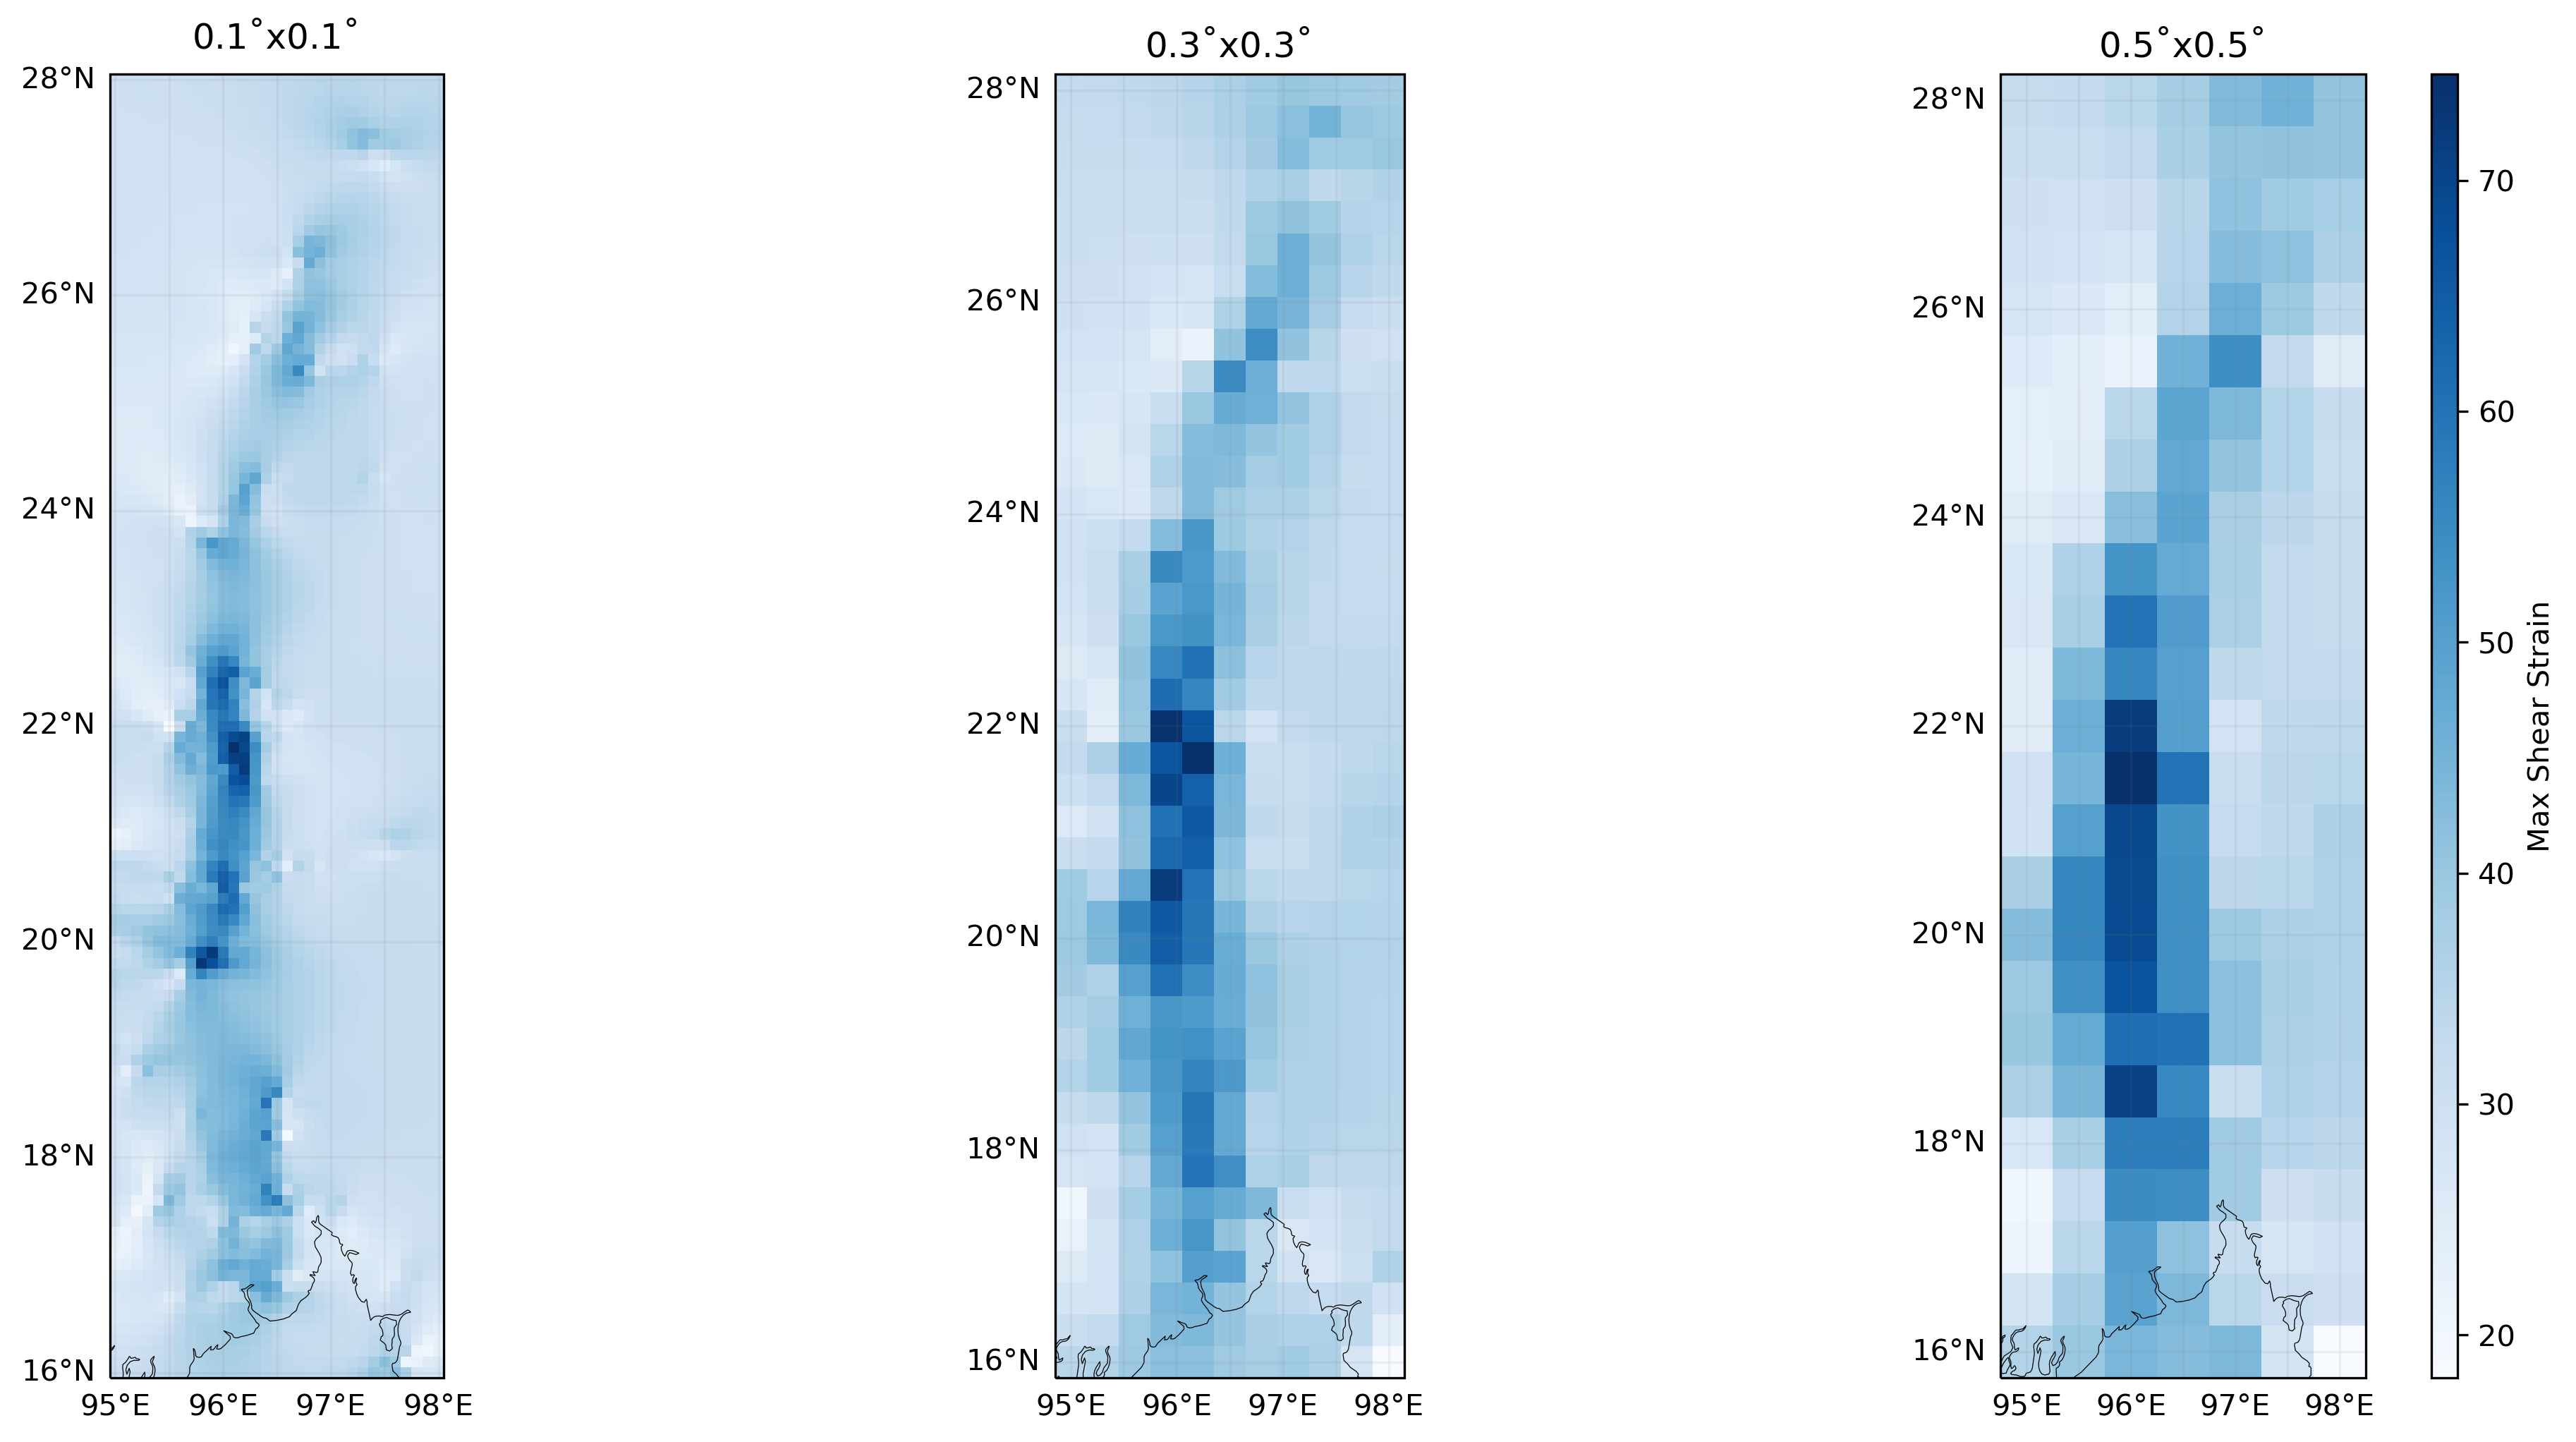

In [4]:
# Plot the results
fig, axes = plt.subplots(1, len(grid_sizes), dpi = 300, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, grid_size in zip(axes, grid_sizes):
    max_shear_file = os.path.join('Output_gpsgridder', f'I{grid_size}_max_shear.nc')
    ds = xr.open_dataset(max_shear_file)
    max_shear = ds['max_shear']

    # Plot the max shear strain
    c = ax.pcolormesh(max_shear['longitude'], max_shear['latitude'], max_shear, transform=ccrs.PlateCarree(), cmap='Blues')
    ax.coastlines(resolution='10m', color='black', linewidth=0.3)
    ax.set_title(f'{grid_size}˚x{grid_size}˚')
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black', 'rotation': 0}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

# Add a single colorbar for all subplots
fig.colorbar(c, ax=axes.ravel().tolist(), orientation='vertical', pad=0.02, aspect=50, label='Max Shear Strain')

# # Save the figure to an 'output' folder
# output_dir = 'output'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# plt.savefig(os.path.join(output_dir, 'strain_rate_comparison.png'), bbox_inches='tight')

# Display the plot
plt.show()